<a href="https://colab.research.google.com/github/SidU/LLMs-from-scratch/blob/main/Embeddings_Intuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Word2Vec to Transformers: Exploring Word Embeddings Through CBOW

[Word2Vec](https://arxiv.org/abs/1301.3781) revolutionized NLP by introducing dense vector representations for words, capturing their semantic relationships in a high-dimensional space. Though modern models like GPT and transformers leverage dynamic, context-aware embeddings, Word2Vec remains essential for understanding the foundations of word representations, gradient-based optimization, and techniques like negative sampling. Its simplicity makes it an excellent starting point: for learning how embeddings work and understanding their role in modern NLP.

In this notebook, we demonstrate the **Continuous Bag of Words (CBOW)** model using PyTorch. You'll learn how to:
1. Set up a vocabulary and initialize an embedding matrix.
2. Retrieve and average embeddings for context words.
3. Predict the target word based on context.
4. Update embeddings during training to improve predictions.

This step-by-step walkthrough bridges the gap between classic NLP methods and advanced techniques in transformer-based models like GPT.

### Import libraries


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

print(torch.__version__)

2.8.0+cu126


## Vocabulary and Embedding Matrix
We'll start by defining a small vocabulary of 4 words "cat", "dog", "mouse", and "cheese" and an embedding size of 3. An embedding layer will store random embeddings for each word initially.

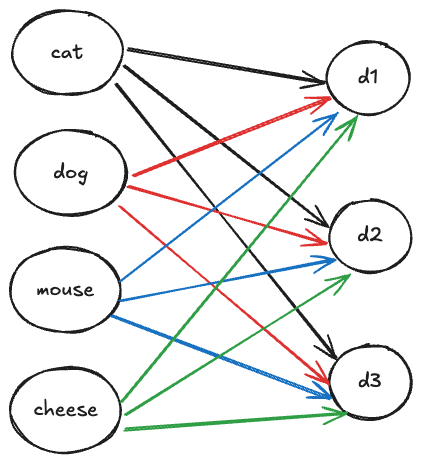


In [ ]:
# Define vocabulary and embedding dimensions
vocab = ["cat", "dog", "mouse", "cheese"]
vocab_size = len(vocab)  # Vocabulary size
embedding_dim = 3  # Embedding dimensions

# Embedding layer
embedding_layer = nn.Embedding(vocab_size, embedding_dim)

# Initialize the embedding matrix randomly
torch.manual_seed(42)  # For reproducibility
print("Initial Embedding Matrix:")
print(embedding_layer.weight.data)

Initial Embedding Matrix:
tensor([[ 0.1972, -0.5918, -0.0442],
        [ 0.9453, -0.0429, -1.0289],
        [ 0.2085, -0.2858,  1.4019],
        [ 0.4854, -0.1622,  1.4818]])


## Context Words and Target Word
We define two context words (`"dog"` and `"mouse"`) and a target word (`"cat"`).
Context words help predict the target word.

In [ ]:
# Define context and target words
context_words = ["dog", "mouse"]  # Context words
target_word = "cat"  # Target word

# Map words to indices
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Convert context words to indices
context_indices = torch.tensor([word_to_idx[word] for word in context_words])  # [1, 2]
print("Context Indices:", context_indices)

Context Indices: tensor([1, 2])


## Retrieve Embeddings for Context Words
Using the indices of the context words, we retrieve their embeddings from the embedding matrix.

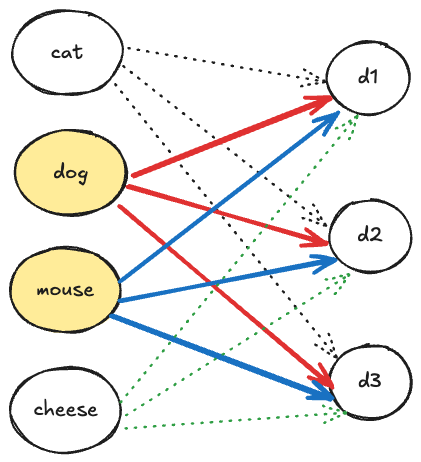

In [ ]:
# Look up embeddings for context words
context_embeddings = embedding_layer(context_indices)
print("Context Embeddings:")
print(context_embeddings)

Context Embeddings:
tensor([[ 0.9453, -0.0429, -1.0289],
        [ 0.2085, -0.2858,  1.4019]], grad_fn=<EmbeddingBackward0>)


## Averaging Context Embeddings
We average the embeddings for context words to form the **context vector**,
which represents the context of the sentence.

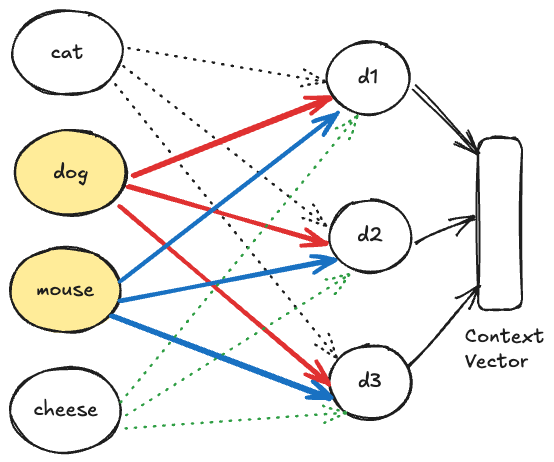

In [ ]:
# Average the embeddings to get the context vector
context_vector = context_embeddings.mean(dim=0) # dim=0 means average along the rows
print("Averaged Context Vector:")
print(context_vector)

Averaged Context Vector:
tensor([ 0.5769, -0.1644,  0.1865], grad_fn=<MeanBackward1>)


## Predict the Target Word
The averaged context vector is passed through a linear layer to predict the target word.
The output is converted into probabilities using the softmax function.


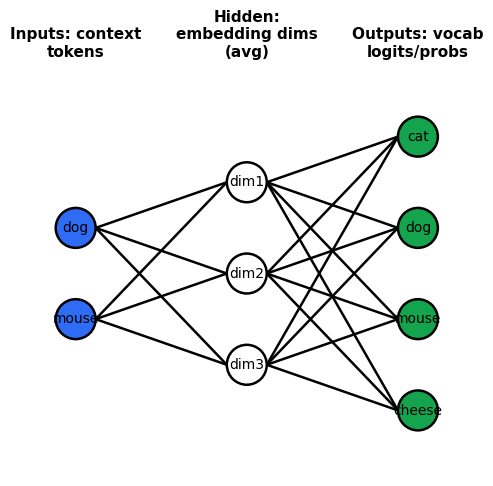

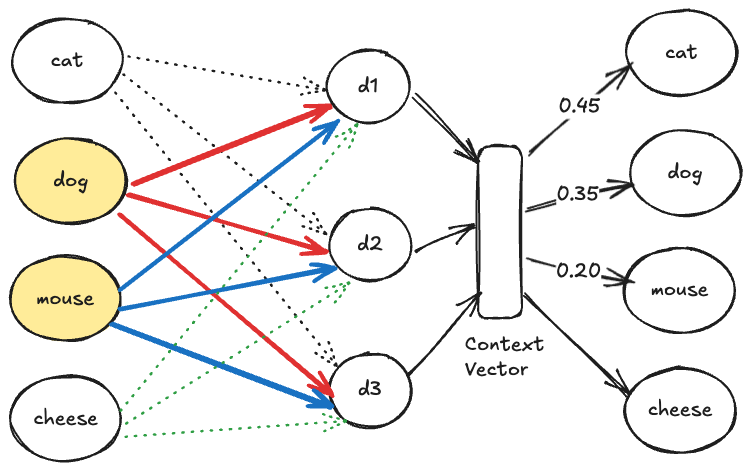

In [ ]:
# Output layer to map context vector to vocabulary
output_layer = nn.Linear(embedding_dim, vocab_size)

# Predict target word
output_logits = output_layer(context_vector)
output_probs = nn.Softmax(dim=-1)(output_logits)
print("Predicted Probabilities for Vocabulary Words:")
print({idx_to_word[i]: p for i, p in enumerate(output_probs.tolist())})

Predicted Probabilities for Vocabulary Words:
{'cat': 0.3636683523654938, 'dog': 0.16659799218177795, 'mouse': 0.3405168950557709, 'cheese': 0.1292167603969574}


## Loss Computation and Backpropagation
We compute the cross-entropy loss between the predicted probabilities and the true target word.
The embedding matrix and linear layer are updated using backpropagation.

In [ ]:
# Define target index
target_index = torch.tensor([word_to_idx[target_word]])  # Index of "cat"

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(list(embedding_layer.parameters()) + list(output_layer.parameters()), lr=0.1)

# Training loop
for epoch in range(10):  # Number of epochs
    optimizer.zero_grad()  # Clear previous gradients

    # Recompute context embeddings for the current parameters
    context_embeddings = embedding_layer(context_indices)  # Get embeddings for context words
    context_vector = context_embeddings.mean(dim=0)  # Average context embeddings

    # Forward pass
    output_logits = output_layer(context_vector)
    loss = criterion(output_logits.unsqueeze(0), target_index)  # Compute loss

    # Backpropagation
    loss.backward()
    optimizer.step()  # Update parameters

    # Print loss for each epoch
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Check updated embedding matrix
print("Updated Embedding Matrix:")
print(embedding_layer.weight.data)

Epoch 1, Loss: 1.063657283782959
Epoch 2, Loss: 0.9755014777183533
Epoch 3, Loss: 0.8950378894805908
Epoch 4, Loss: 0.8216667771339417
Epoch 5, Loss: 0.7548377513885498
Epoch 6, Loss: 0.6940373778343201
Epoch 7, Loss: 0.6387811899185181
Epoch 8, Loss: 0.5886109471321106
Epoch 9, Loss: 0.5430923104286194
Epoch 10, Loss: 0.5018148422241211
Updated Embedding Matrix:
tensor([[ 0.1972, -0.5918, -0.0442],
        [ 1.0958,  0.0272, -1.1151],
        [ 0.3589, -0.2157,  1.3157],
        [ 0.4854, -0.1622,  1.4818]])


### Test Phase: Verify the Model’s Learning

After training, we test the model to ensure it has learned the relationship between the context words and the target word.

In this test, we use the trained embeddings and output layer to:

1.	Recompute the context vector from the test context words ("dog" and "mouse").
2.	Predict the target word ("cat") using the trained model.
3.	Compare the predicted word with the actual target word to check if the model learned correctly.

The test phase does not update the model weights, and no gradients are computed during this process.

In [ ]:
# Test phase
embedding_layer.eval()  # Set embedding layer to evaluation mode
output_layer.eval()  # Set output layer to evaluation mode

# Test context words and target
test_context_words = ["dog", "mouse"]
test_context_indices = torch.tensor([word_to_idx[word] for word in test_context_words])  # Indices for "dog" and "mouse"

# Recompute context vector for test context
with torch.no_grad():  # Disable gradient computations during testing
    test_context_embeddings = embedding_layer(test_context_indices)  # Get embeddings for test context
    test_context_vector = test_context_embeddings.mean(dim=0)  # Average embeddings

    # Predict the target word
    test_logits = output_layer(test_context_vector)  # Forward pass
    test_probs = nn.Softmax(dim=-1)(test_logits)  # Compute probabilities
    predicted_index = torch.argmax(test_probs).item()  # Get the index of the highest probability word
    predicted_word = idx_to_word[predicted_index]  # Map index to word

# Print the test result
print(f"Context Words: {test_context_words}")
print(f"Predicted Word: {predicted_word}")
print(f"Actual Target Word: {target_word}")

# Check if the prediction matches the target word
if predicted_word == target_word:
    print("The model correctly predicted the target word!")
else:
    print("The model failed to predict the target word.")

Context Words: ['dog', 'mouse']
Predicted Word: cat
Actual Target Word: cat
The model correctly predicted the target word!


### Intuition: How Backpropagation Shapes Word Embeddings

Word embeddings are learned during training to reflect the relationships between words based on their **context**. Here's how:

1. **Words Used in Similar Contexts Are Pulled Closer**:  
   - For example, if "dog" and "cat" often appear near similar words (like "pet" or "furry"), their embeddings move closer in the vector space.
   
2. **Error Correction Through Backpropagation**:  
   - When the model predicts a target word (e.g., "cat") given context words (e.g., "dog," "mouse") and gets it wrong, the error is backpropagated.  
   - This adjusts embeddings for:
     - The **target word** ("cat") to make it easier to predict in similar contexts in the future.  
     - The **context words** ("dog," "mouse") to better represent the context of "cat."

3. **Iterative Refinement**:  
   - Over time, embeddings for words frequently seen together are adjusted to be closer, while embeddings for unrelated words remain far apart.  
   - This process encodes semantic relationships, approximating word "meaning" in the vector space.


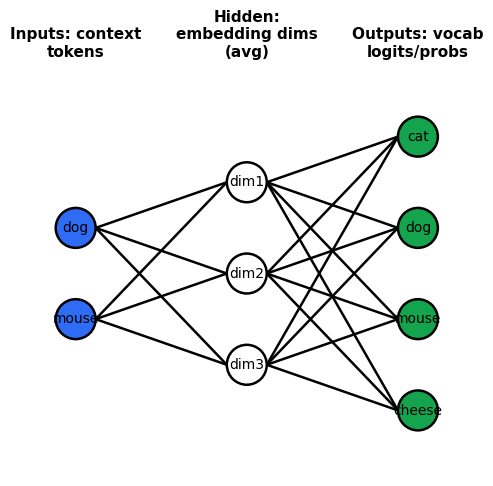

In [ ]:
import matplotlib.pyplot as plt
import textwrap

def draw_fc_network_fixed_labels(
    layer_sizes, node_labels=None, layer_titles=None,
    layer_gap=3.0, vert_gap=1.6, radius=0.35, lw=1.8,
    colors=("#2E6CF6","#FFFFFF","#14A44D"), title_wrap=16, figsize=(14,6)
):
    L = len(layer_sizes)
    max_nodes = max(layer_sizes)
    xs = [i * layer_gap for i in range(L)]
    ys_per_layer = []
    for s in layer_sizes:
        total_h = (s - 1) * vert_gap
        top = total_h / 2.0
        ys_per_layer.append([top - j * vert_gap for j in range(s)])

    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off"); ax.set_aspect("equal")

    def layer_color(i):
        if i == 0: return colors[0]
        if i == L-1: return colors[2]
        return colors[1]

    # edges
    for i in range(L-1):
        for y1 in ys_per_layer[i]:
            for y2 in ys_per_layer[i+1]:
                ax.plot([xs[i]+radius, xs[i+1]-radius], [y1, y2],
                        color="black", lw=lw, zorder=1)

    # nodes + node labels
    for i in range(L):
        for j, y in enumerate(ys_per_layer[i]):
            circ = plt.Circle((xs[i], y), radius, fc=layer_color(i),
                              ec="black", lw=lw, zorder=2)
            ax.add_patch(circ)
            if node_labels:
                ax.text(xs[i], y, node_labels[i][j],
                        ha="center", va="center", fontsize=10, zorder=3)

    # layer titles (wrapped, boxed, above column)
    if layer_titles:
        top_y = (max_nodes - 1) * vert_gap / 2.0
        for i, ttl in enumerate(layer_titles):
            wrapped = "\n".join(textwrap.wrap(ttl, width=title_wrap))
            ax.text(xs[i], top_y + radius + 1.0, wrapped,
                    ha="center", va="bottom", fontsize=11, fontweight="600",
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.8))

    # margins
    xmin, xmax = -radius - 0.8, xs[-1] + radius + 0.8
    ymin = -((max_nodes - 1) * vert_gap / 2.0) - radius - 0.8
    ymax = ((max_nodes - 1) * vert_gap / 2.0) + radius + 1.8
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    plt.show()


# Example (your CBOW toy net)
vocab   = ["cat", "dog", "mouse", "cheese"]
context = ["dog", "mouse"]
D = 3

layer_sizes  = [len(context), D, len(vocab)]
node_labels  = [context, [f"dim{i+1}" for i in range(D)], vocab]
layer_titles = ["Inputs: context tokens",
                "Hidden: embedding dims (avg)",
                "Outputs: vocab logits/probs"]

draw_fc_network_fixed_labels(layer_sizes, node_labels=node_labels, layer_titles=layer_titles)


# Appendix

### **Cross-Entropy Loss**
In our neural network, the **cross-entropy loss** measures how well the model's predictions match the true labels.

For example:
- The true label is "cat," represented as a one-hot vector `[1, 0, 0]`.
- The model predicts probabilities `[0.7, 0.2, 0.1]` for "cat," "dog," and "mouse."

The loss is calculated using:
${Loss}$ = - $\sum_{i=1}^{C} y_i log(\hat{y}_i)$

- $C$: Number of classes.
- $y_i$: True label for class $i$ (1 for the correct class, 0 otherwise).
- $\hat{y}_i$: Predicted probability for class $i$.

For this example:
${Loss} = - (\log(0.7)) \approx 0.356
$]

A smaller loss means the model is predicting more accurately.

In [ ]:
import torch
import torch.nn.functional as F

# True class index (e.g., "cat" corresponds to index 0)
true_label_index = torch.tensor([0])  # Class 0 is the true label

# Raw logits (model output before applying softmax)
logits = torch.tensor([[2.0, 1.0, 0.1]], requires_grad=True)

# **Manual Calculation**
# Step 1: Apply log-softmax to logits
log_softmax = torch.log_softmax(logits, dim=1)  # Log probabilities for each class
# Step 2: Extract the log probability of the true class
loss_manual = -log_softmax[0, true_label_index]

# **Using PyTorch Built-in Cross-Entropy Loss**
criterion = torch.nn.CrossEntropyLoss()
loss_builtin = criterion(logits, true_label_index)

# Print results
print(f"Manual Loss: {loss_manual.item():.4f}")
print(f"PyTorch Loss: {loss_builtin.item():.4f}")

Manual Loss: 0.4170
PyTorch Loss: 0.4170


### **Stochastic Gradient Descent (SGD)**
**SGD** is the algorithm used to minimize the loss by updating the model's weights. Here's how it works:
1. **Calculate the Gradient**: The gradient tells us how the weights need to change to reduce the loss.
2. **Update the Weights**:

$$w_{\text{new}} = w_{\text{old}} - \eta \cdot \frac{\partial \text{Loss}}{\partial w}$$

- $w$: Weight.
- $\eta$: Learning rate (controls step size).

In our example, after calculating the loss, we use SGD to adjust the model's weights to better predict the next time.


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

# Initialize logits (weights to optimize)
manual_logits = torch.tensor([[2.0, -1.0]], requires_grad=True)  # For manual SGD
pytorch_logits = torch.tensor([[2.0, -1.0]], requires_grad=True)  # For PyTorch SGD

# True label (class index)
true_label = torch.tensor([0])  # Class 0 is the correct class

# Learning rate
learning_rate = 0.1

# Define PyTorch optimizer
optimizer = optim.SGD([pytorch_logits], lr=learning_rate)

print(f"Starting Logits: Manual = {manual_logits}, PyTorch = {pytorch_logits}\n")

# Training loop
for epoch in range(10):
    # ---- Manual SGD ----
    # Compute Cross-Entropy Loss (manually)
    manual_loss = F.cross_entropy(manual_logits, true_label)  # Takes raw logits and class index

    # Backpropagation
    manual_loss.backward()

    # Update logits using manual SGD
    with torch.no_grad():
        manual_logits -= learning_rate * manual_logits.grad  # Gradient descent step
        manual_logits.grad.zero_()  # Clear gradients

    # ---- PyTorch SGD ----
    # Compute Cross-Entropy Loss
    pytorch_loss = F.cross_entropy(pytorch_logits, true_label)

    # Backpropagation
    optimizer.zero_grad()
    pytorch_loss.backward()
    optimizer.step()  # PyTorch's built-in SGD

    # Print progress
    print(f"Epoch {epoch+1}")
    print(f"  Manual: Loss = {manual_loss.item():.4f}, Logits = {manual_logits}")
    print(f"  PyTorch: Loss = {pytorch_loss.item():.4f}, Logits = {pytorch_logits}\n")

Starting Logits: Manual = tensor([[ 2., -1.]], requires_grad=True), PyTorch = tensor([[ 2., -1.]], requires_grad=True)

Epoch 1
  Manual: Loss = 0.0486, Logits = tensor([[ 2.0047, -1.0047]], requires_grad=True)
  PyTorch: Loss = 0.0486, Logits = tensor([[ 2.0047, -1.0047]], requires_grad=True)

Epoch 2
  Manual: Loss = 0.0481, Logits = tensor([[ 2.0094, -1.0094]], requires_grad=True)
  PyTorch: Loss = 0.0481, Logits = tensor([[ 2.0094, -1.0094]], requires_grad=True)

Epoch 3
  Manual: Loss = 0.0477, Logits = tensor([[ 2.0141, -1.0141]], requires_grad=True)
  PyTorch: Loss = 0.0477, Logits = tensor([[ 2.0141, -1.0141]], requires_grad=True)

Epoch 4
  Manual: Loss = 0.0473, Logits = tensor([[ 2.0187, -1.0187]], requires_grad=True)
  PyTorch: Loss = 0.0473, Logits = tensor([[ 2.0187, -1.0187]], requires_grad=True)

Epoch 5
  Manual: Loss = 0.0468, Logits = tensor([[ 2.0233, -1.0233]], requires_grad=True)
  PyTorch: Loss = 0.0468, Logits = tensor([[ 2.0233, -1.0233]], requires_grad=True)

